In [1]:
dataset <- "ARPALombardia"
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Lombardia"
match_dist <- 20000
new_dataset <- "LOM"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [4]:
ds_meta <- query_checkpoint_meta(dataset, "hext", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!(state %in% c("Piemonte", "Veneto", "Trentino-Alto Adige", "Emilia-Romagna")))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(c("SCIA", "ISAC"), "qc1", conns$data) |>
    filter(valid) |>
    select(!c(starts_with("qc_"), valid)) |>
    rows_append(query_checkpoint_data(dataset, "hext", conns$data)) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key"))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [7]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, epsilon = 0.1)
# analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "ds_regionali", state, "raw_analysis.parquet"))


In [9]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    mutate(tag_mergeable = TRUE) |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(
    tagged_analysis,
    file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"),
    starts_with("user_code"),
    starts_with("sensor_id"),
    starts_with("station_id"),
    starts_with("series_id"),
    starts_with("tag_")
)


In [7]:
actual_lom_meta <- query_checkpoint_meta("ARPALombardia", "qc1", conns$data)
actual_lom_data <- query_checkpoint_data("ARPALombardia", "qc1", conns$data) |>
    filter(valid) |>
    select(!c(starts_with("qc_"), valid)) |>
    inner_join(actual_lom_meta, by = c("dataset", "sensor_key"))
translation <- inner_join(ds_meta |> select(dataset, sensor_key, sensor_id), actual_lom_meta |> select(dataset, sensor_key, sensor_id) |> collect(), by = c("dataset", "sensor_id"))
a_ <- translation |> assertr::verify(sensor_key.x == sensor_key.y)
# All sensor keys are the same, no need to go further

actual_metadata <- bind_rows(actual_lom_meta |> collect(), nat_meta) |>
    left_join(metadata |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    arrange(key, dataset, sensor_key) |>
    mutate(key = coalesce(key, row_number()))
a_ <- actual_metadata |>
    group_by(key) |>
    tally() |>
    assertr::verify(n == 1L)

actual_metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

actual_data <- query_checkpoint_data(c(dataset, "SCIA"), "qc1", conns$data) |>
    filter(valid) |>
    select(!c(starts_with("qc_"), valid)) |>
    inner_join(actual_metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key"))


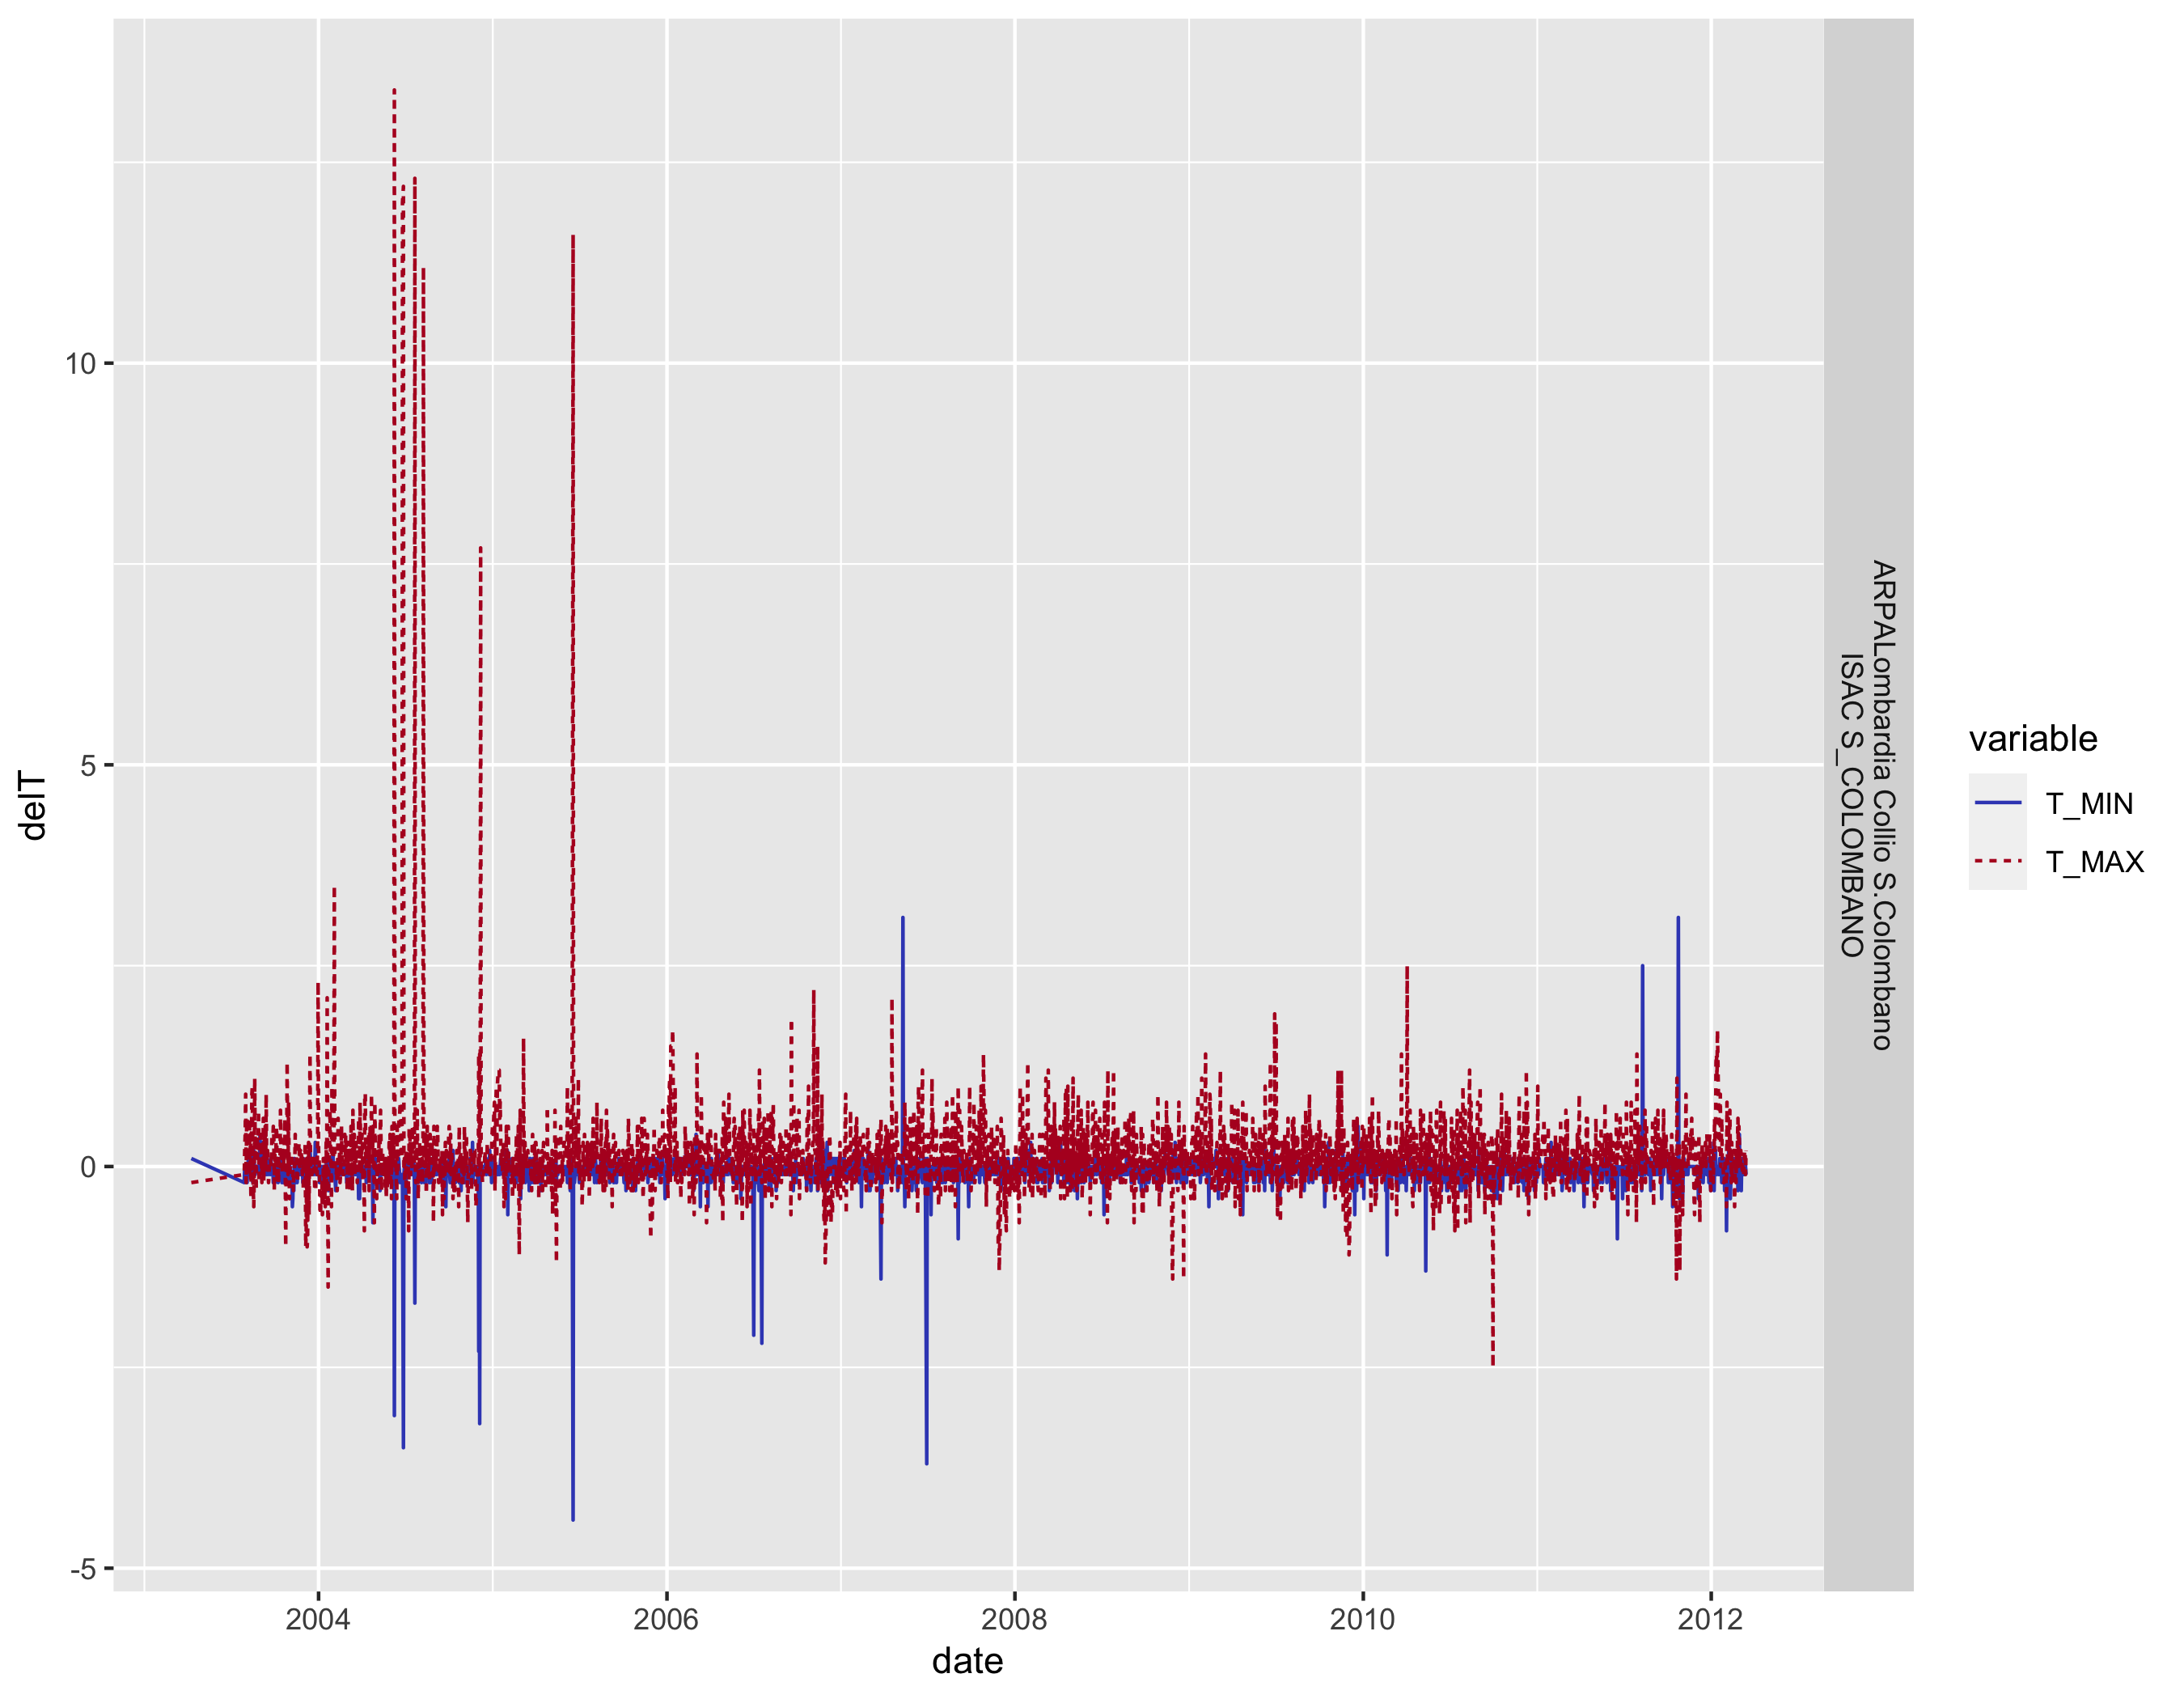

In [11]:
tagged_analysis |>
    filter(sensor_key_x == 98L, sensor_key_y == 2956L) |>
    plot_diffs(data)


In [18]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, merging_datasets, desc(dataset), desc(sensor_last))
ignore_corrections <- NULL
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 5L, 0.5, ignore_corrections)


In [19]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,sensor_key_x,name_y,network_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
30,-3.87670455,0.00000000,0.00000000,0.00000000,15,50,408,1,0,San Rocco al Porto v.Matteotti,ARPALombardia,50,S.Rocco_al_Porto,Idrografica,2735
29,1.47211588,3.16182284,0.65104658,0.52852303,15,50,408,-1,0,San Rocco al Porto v.Matteotti,ARPALombardia,50,S.Rocco_al_Porto,Idrografica,2735
172,2.68323353,0.00000000,0.00000000,0.00000000,86,250,347,1,0,Lanzada Ganda,ARPALombardia,250,Lanzada,Idrografica,1529
141,1.13542609,1.92877922,-0.05301094,0.46237222,71,196,299,-1,-1,Chiavenna v.Cerletti,ARPALombardia,196,Chiavenna,Idrografica,868
9,2.38279153,-0.26066650,0.20000918,0.03911904,5,21,384,-1,-1,Pavia v. Folperti,ARPALombardia,21,Pavia,Idrografica,2341
1,-2.48017891,0.78518602,-0.21332880,-0.30978522,3,13,300,-1,0,Clusone Campo Sportivo,ARPALombardia,13,Clusone,Idrografica,902
3,2.21873381,-0.45720098,0.20288626,0.16586588,11,40,382,-1,-1,Edolo Pantano d`Avio,ARPALombardia,40,Pantano_d'Avio,Idrografica,2299
129,2.40195271,-0.99096848,0.21721118,0.06989596,65,187,342,-1,-1,San Giacomo Filippo Lago Truzzo,ARPALombardia,187,Lago_Truzzo_-_S.Giacomo_Filippo,Idrografica,1516
159,2.61572597,-1.55865734,-0.29577458,0.02153291,80,225,422,-1,0,Madesimo Spluga,ARPALombardia,225,Stuetta,Idrografica,3053


In [20]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 10, ignore_corrections, contribution_threshold = 0L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2285241,122.1,4498680,240.3,NA,4498680,240.3
Vcells,45834688,349.7,121786651,929.2,16384,121786651,929.2


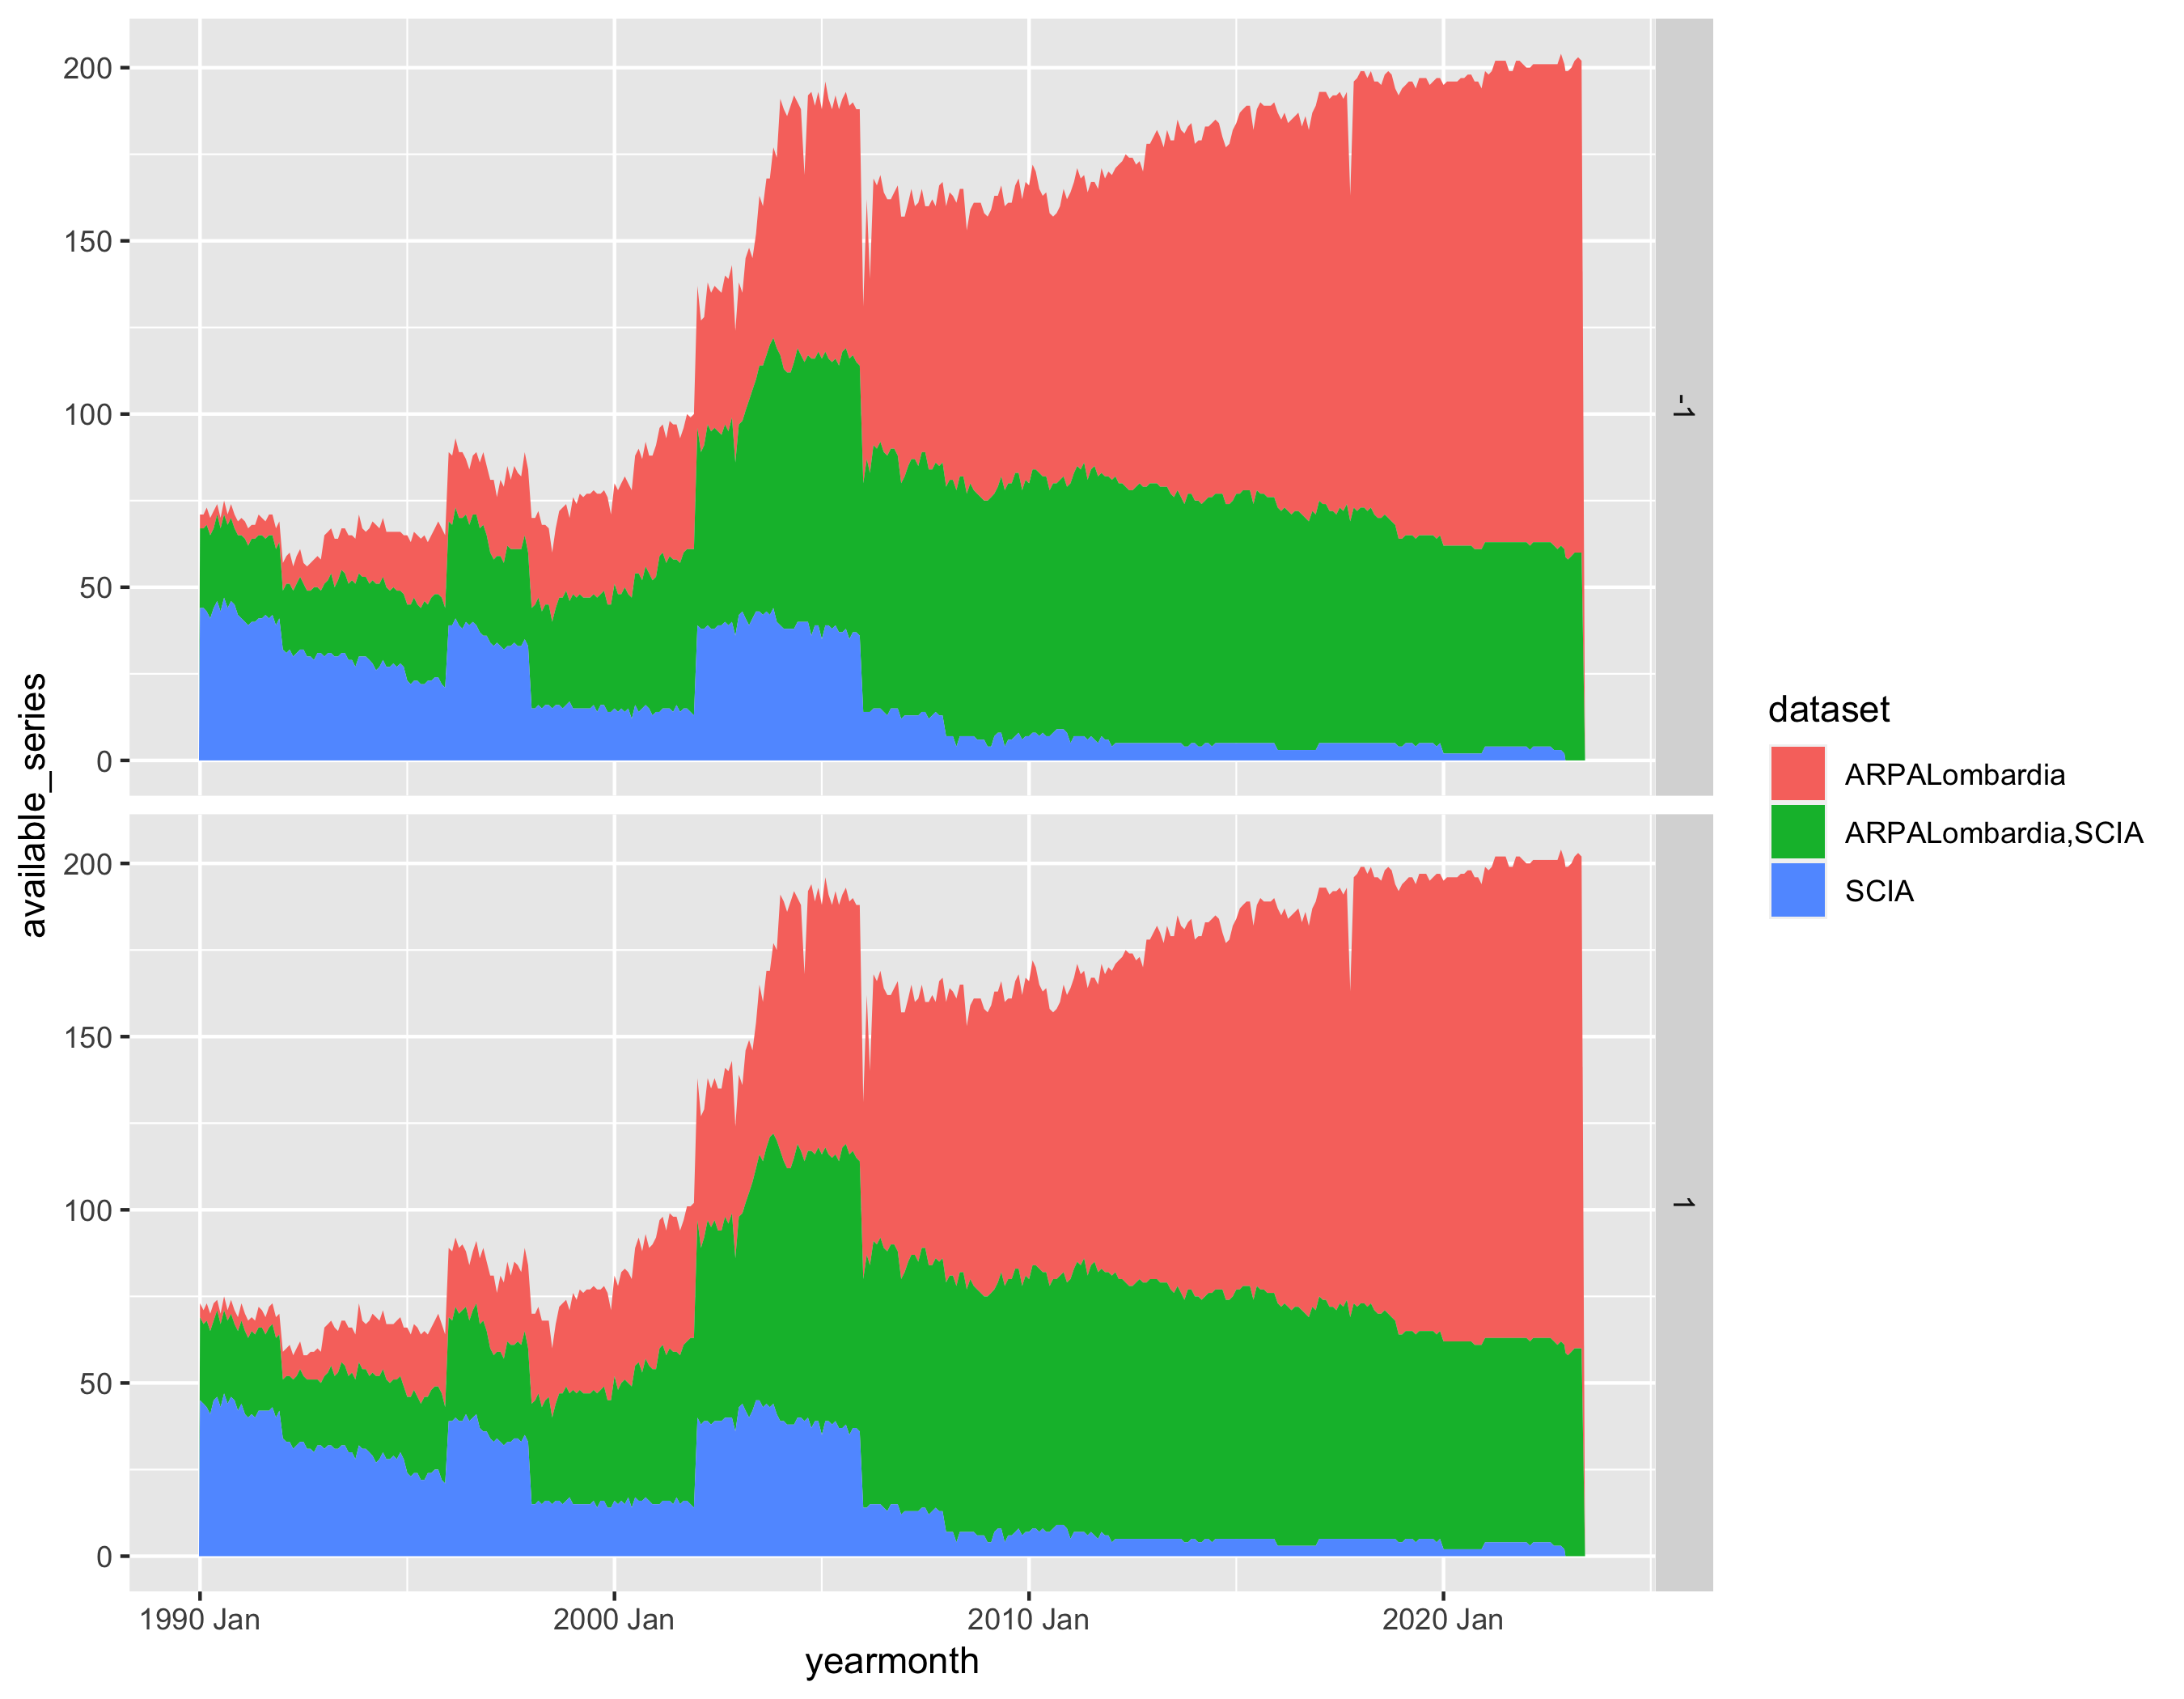

In [21]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


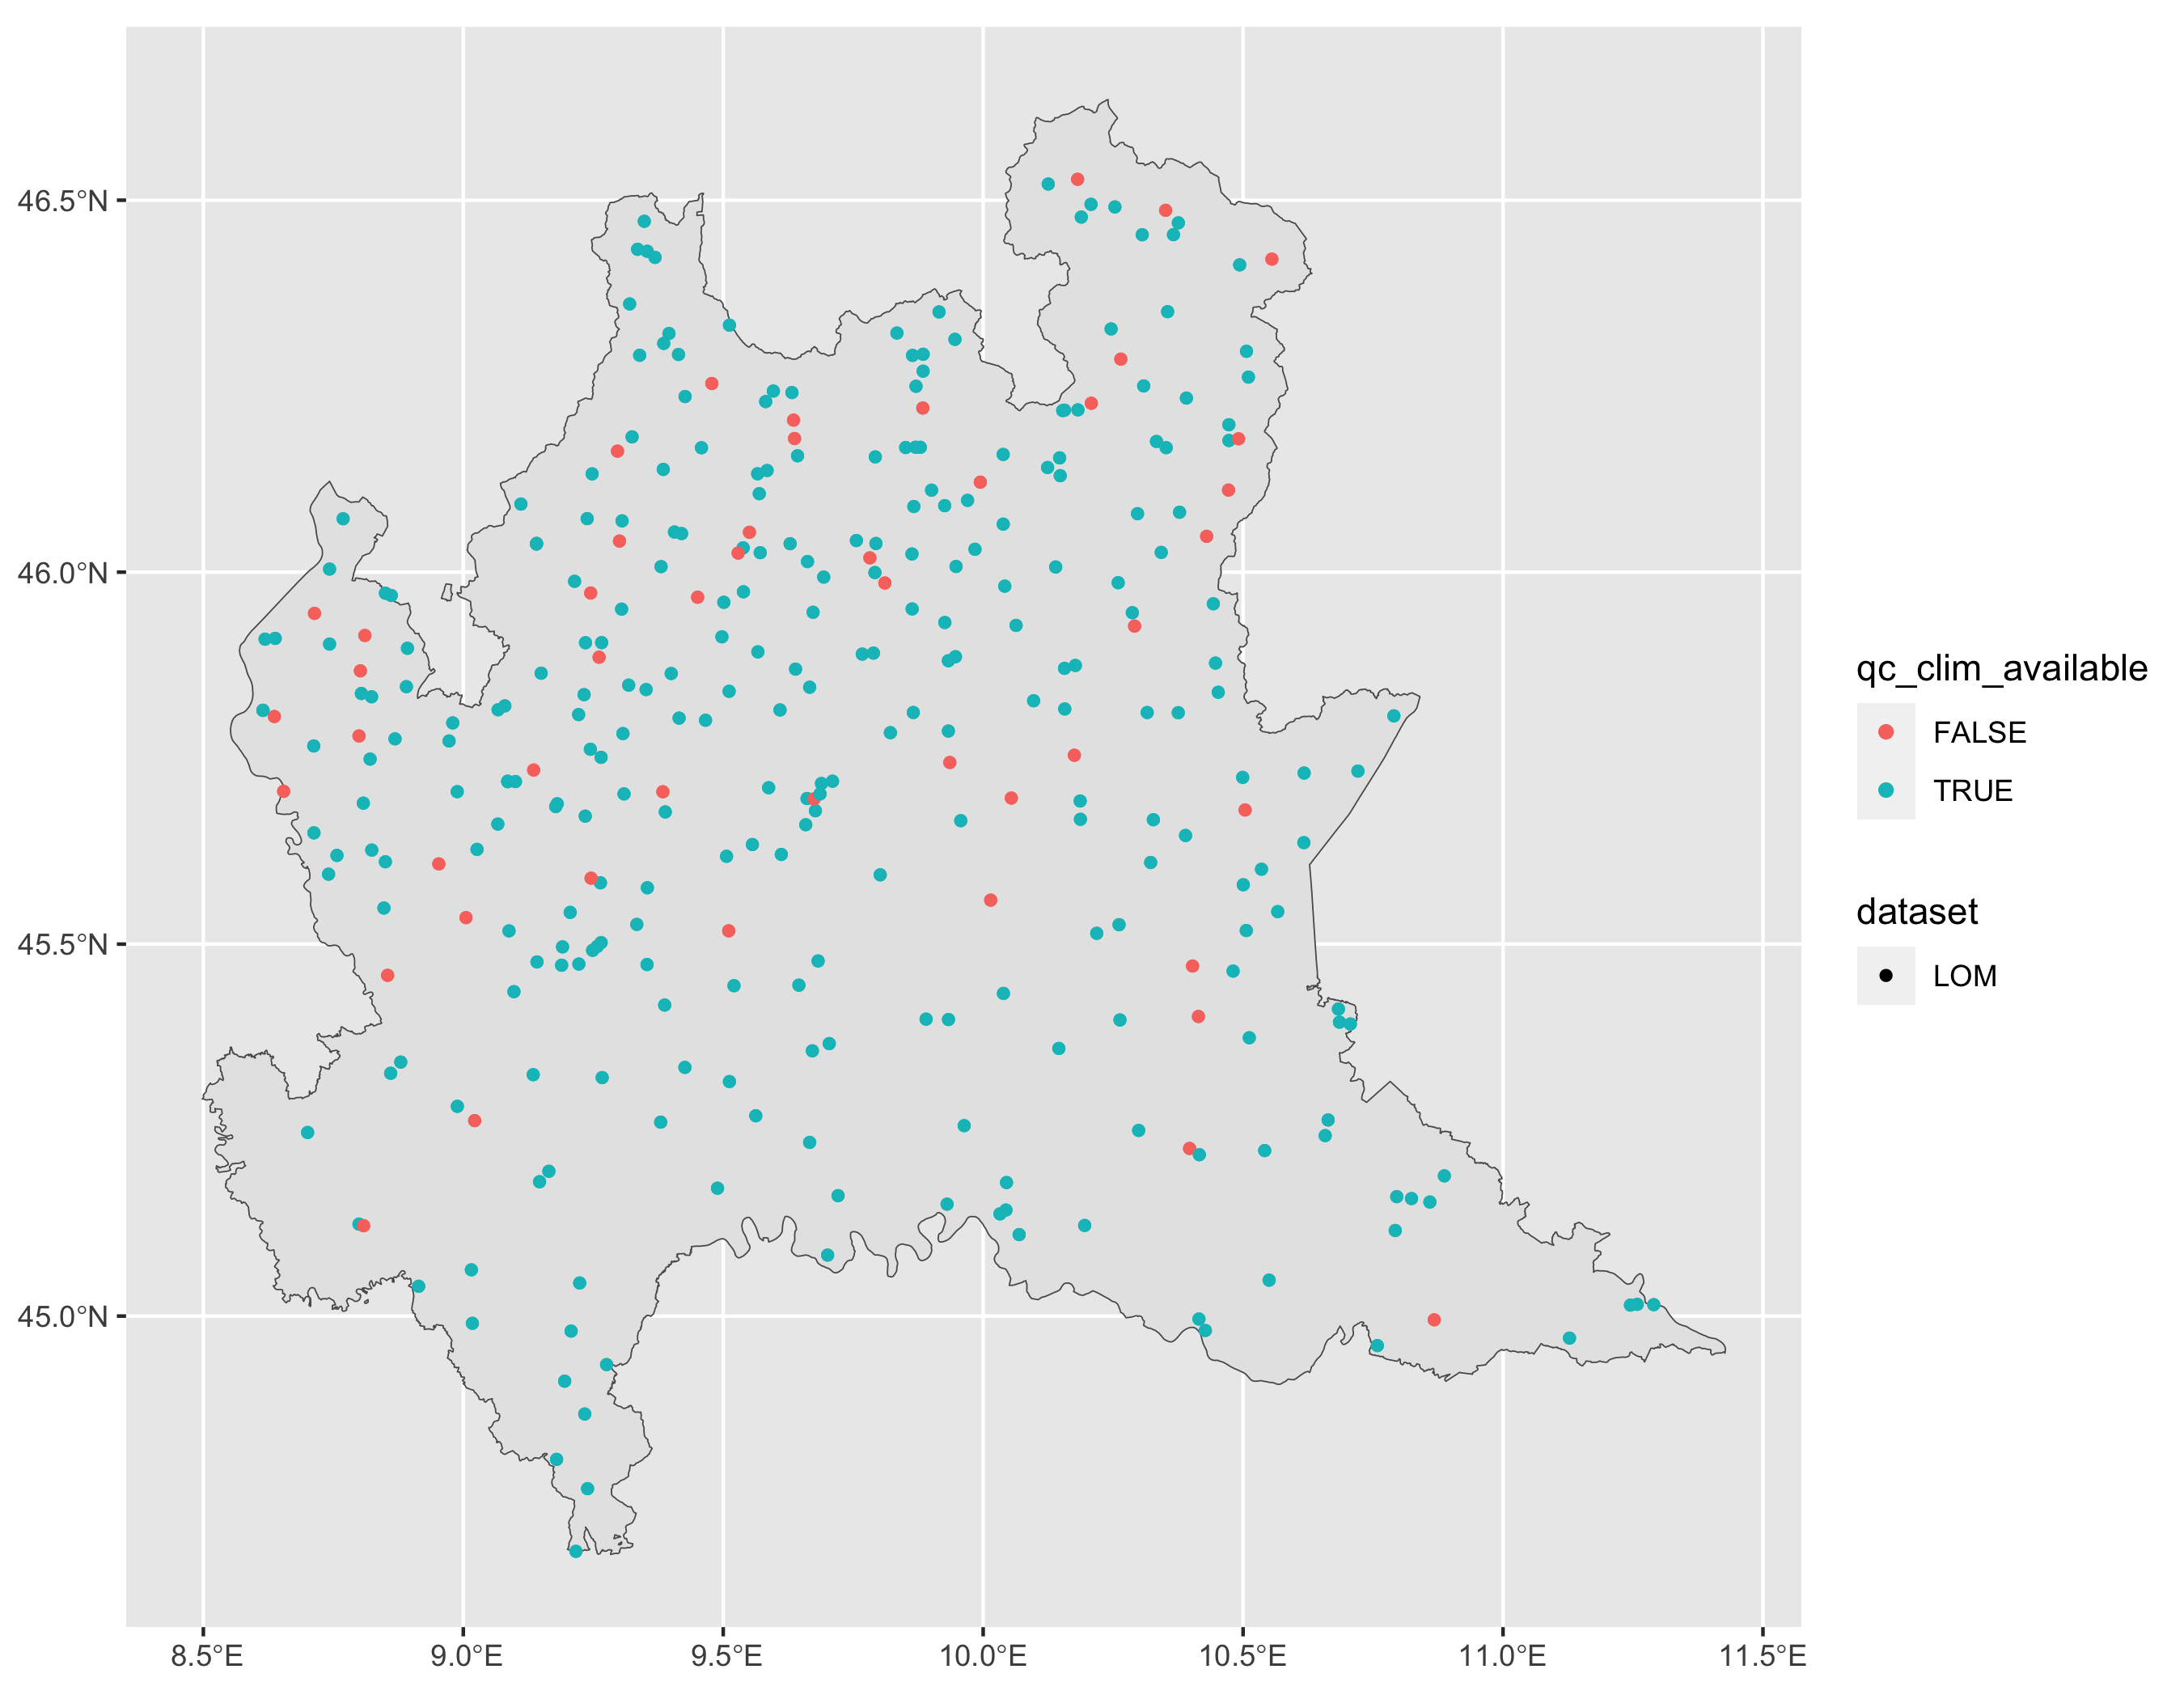

In [22]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot


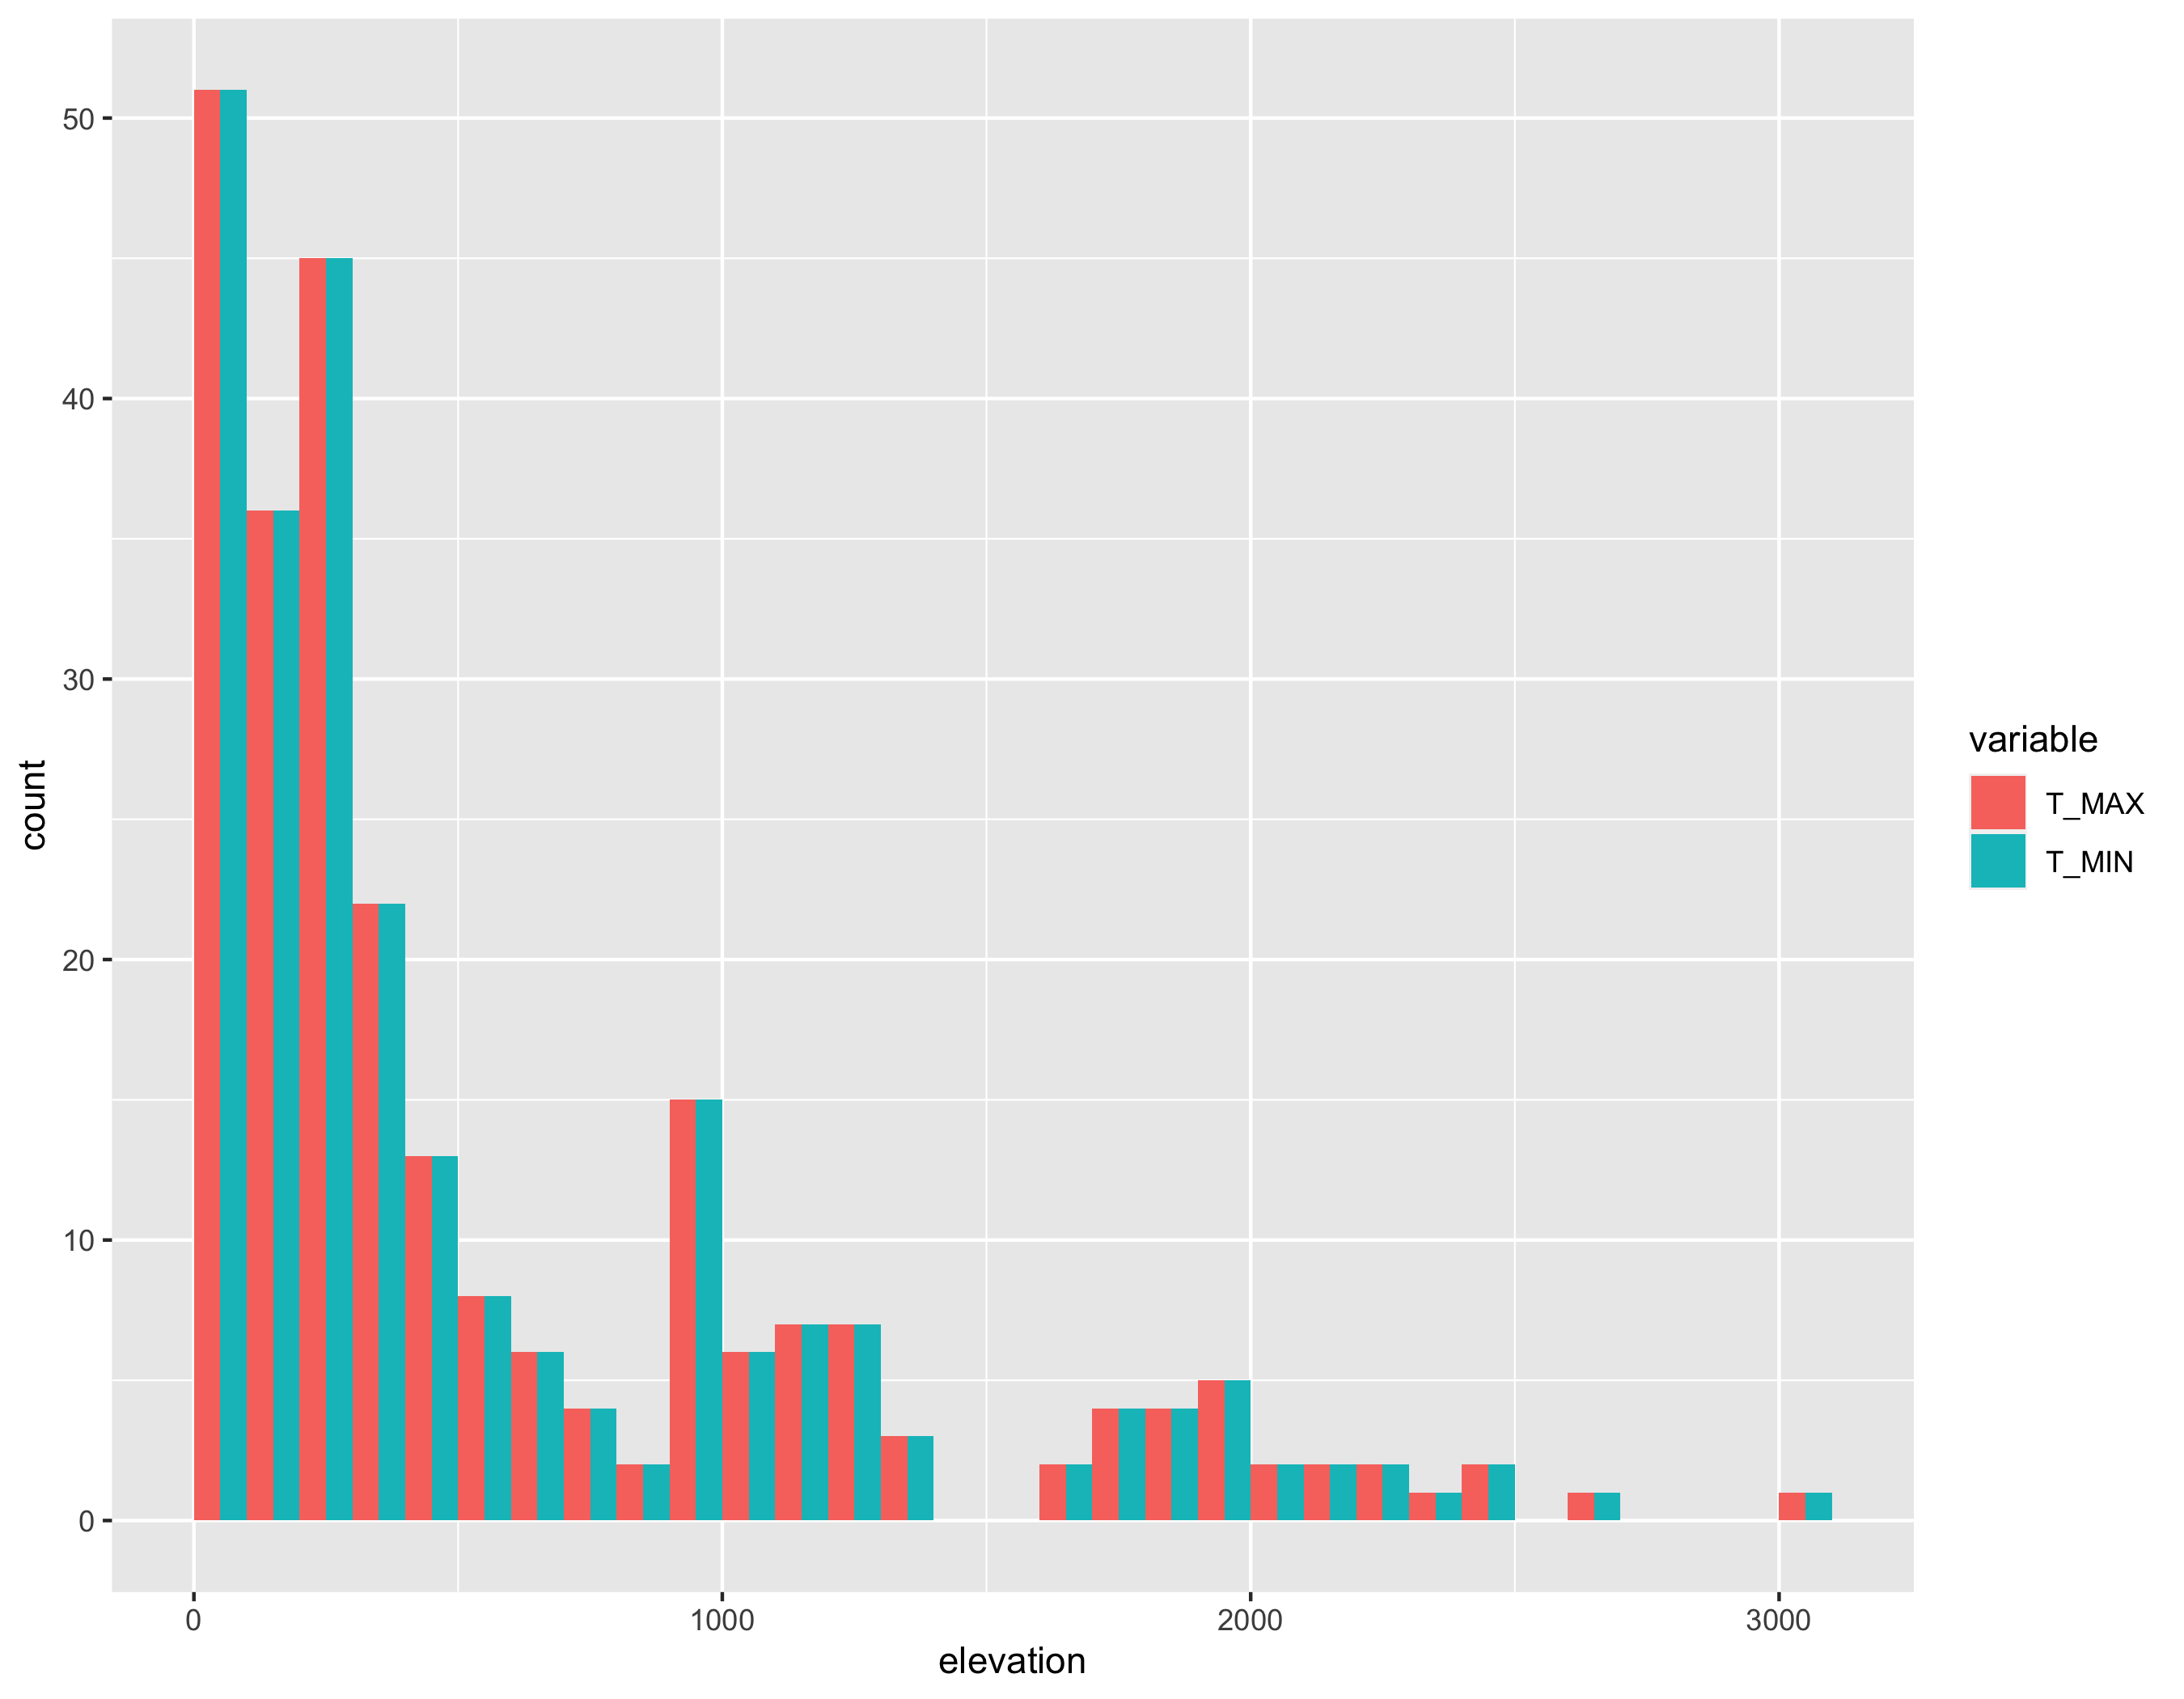

In [22]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())


In [13]:
source("src/merging/display.R")
show_merge(db$meta, metadata_db, "network", "lon", "lat", "elevation", "sensor_first", "sensor_last") |>
    arrange(master_key) |>
    write.xlsx("lom.xlsx", asTable = TRUE)
